# 計量経済学的線形回帰分析 - ウォークスルー

このNotebookは、線形回帰モデルの推定と限界効果分析の基本的なワークフローを示します。

## セットアップ

必要なライブラリをインポートします。

In [167]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

# Add src to path
src_path = Path("../src")
sys.path.insert(0, str(src_path.absolute()))

from regression import (
    DoubLogRegressionModel,
    LinearRegressionModel,
    MarginalEffectsCalculator,
)

## 1. サンプルデータの生成

線形回帰分析用のサンプルデータを生成します。

- **Sales**: 売上（目的変数）
- **Advertising**: 広告費（説明変数）
- **Price**: 価格（説明変数）

関係式: Sales = 500 + 3*Advertising - 1*Price + noise

In [168]:
# データ生成用の乱数シードを設定
np.random.seed(42)
n = 100

# 説明変数
advertising = np.linspace(10, 100, n)
price = np.linspace(50, 200, n)

# 目的変数: Sales = 500 + 3*Advertising - 1*Price + noise
sales = 500 + 3 * advertising - 1 * price + np.random.normal(0, 50, n)

# DataFrameの作成
df = pd.DataFrame(
    {
        "Sales": sales,
        "Advertising": advertising,
        "Price": price,
    }
)

print("【データセット要約】")
print(df.describe())

【データセット要約】
            Sales  Advertising       Price
count  100.000000   100.000000  100.000000
mean   534.807674    55.000000  125.000000
std     58.657257    26.374084   43.956806
min    400.093564    10.000000   50.000000
25%    492.193874    32.500000   87.500000
50%    533.854917    55.000000  125.000000
75%    577.927020    77.500000  162.500000
max    653.288642   100.000000  200.000000


## 2. モデルのフィッティング

線形回帰モデルを推定します。

In [169]:
# モデルの推定
print("【モデルのフィッティング】")
model = LinearRegressionModel()
model.fit(df[["Advertising", "Price"]], df["Sales"])
print("✓ モデルのフィッティング完了")

【モデルのフィッティング】
✓ モデルのフィッティング完了


## 3. 回帰分析の結果

統計サマリーと推定係数を表示します。

In [170]:
# 統計サマリー
print("【回帰分析の結果】")
print(model.summary())

【回帰分析の結果】
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     65.85
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           1.44e-12
Time:                        21:38:47   Log-Likelihood:                -522.86
No. Observations:                 100   AIC:                             1050.
Df Residuals:                      98   BIC:                             1055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4792      0.044     33

In [171]:
# 係数の取得
print("【推定係数】")
coef_df = model.get_coefficients()
print(coef_df)

【推定係数】
             Coefficient  Std Error  t-statistic       p-value
const           1.479156   0.043850    33.732089  9.693402e-56
Advertising   -21.379066   0.688088   -31.070253  1.543494e-52
Price          13.673417   0.316330    43.225150  1.247676e-65


## 4. 限界効果分析

各説明変数の限界効果を計算します。
限界効果は、ある変数が1単位増加したときに目的変数がどの程度変化するかを示します。

In [172]:
# 限界効果の計算
print("【限界効果分析】")
calculator = MarginalEffectsCalculator(model)

for var in ["Advertising", "Price"]:
    me = calculator.marginal_effect(var)
    print(f"\n{var}:")
    print(f"  限界効果: {me:.4f}")
    print(f"  解釈: {var}が1単位増加すると、売上は{me:.4f}単位変化します")

【限界効果分析】

Advertising:
  限界効果: -21.3791
  解釈: Advertisingが1単位増加すると、売上は-21.3791単位変化します

Price:
  限界効果: 13.6734
  解釈: Priceが1単位増加すると、売上は13.6734単位変化します


## Visualization: Linear Regression Model

This visualization shows the relationship between Advertising and Sales.
The vertical line indicates the marginal effect at the mean value.

In [173]:
# Mark mean point and marginal effect
x_mean = df["Advertising"].mean()
price_mean = df["Price"].mean()

# 平均点での予測売上を計算
mean_features = pd.DataFrame({"Advertising": [x_mean], "Price": [price_mean]})
y_mean = float(model.predict(mean_features)[0])

# Add vertical line to show marginal effect slope
me_adv = calculator.marginal_effect("Advertising")
x_point = x_mean
y_point = y_mean

## 5. 弾力性分析

弾力性は、パーセンテージ変化に対する反応度を示します。
例えば、広告費が1%増加するときに売上が何%変化するかを測定します。

In [174]:
# 弾力性の計算
print("【弾力性分析】")
x_mean_adv = df["Advertising"].mean()
y_pred_mean = model.predict(df[["Advertising", "Price"]]).mean()

elasticity_adv = calculator.elasticity("Advertising", x_mean_adv, y_pred_mean)
print(f"\n広告費の弾力性: {elasticity_adv:.6f}")
print(f"解釈: 広告費が1%増加するとき、売上は{elasticity_adv:.4f}%変化します")

【弾力性分析】

広告費の弾力性: -2.198638
解釈: 広告費が1%増加するとき、売上は-2.1986%変化します


## 6. 応答性分析

広告費の変化に対する売上の応答性を詳細に分析します。

In [175]:
# 応答性分析
print("【応答性分析（広告費）】")
responsiveness = calculator.responsiveness_analysis(
    "Advertising", percentile_change=1.0
)
for key, value in responsiveness.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

【応答性分析（広告費）】
  variable: Advertising
  base_x_mean: 55.000000
  base_y_mean: 534.807674
  percentage_change_x: 1.000000
  absolute_x_change: 0.550000
  absolute_y_effect: -11.758486
  percentage_y_effect: -2.198638


---

# 両対数モデル - 飽和点検出デモ

べき乗法則に従う関係性をモデル化する両対数モデルを使用します。
このモデルは、限界効果が逓減していく状況を捉えるのに適しています。

## 7. 両対数データの生成

マーケティング予算と売上の関係を、逓減効果のあるべき乗法則で生成します。

In [176]:
# 両対数データの生成（べき乗法則）
np.random.seed(123)
n = 1000
marketing_budget = np.linspace(50, 10_000, n)
revenue = 5000 * (marketing_budget**0.01) + np.random.normal(0, 50, n)

df_doublog = pd.DataFrame({"Revenue": revenue, "Marketing": marketing_budget})
# df_doublog.loc[df_doublog["Revenue"] < 0, "Revenue"] = 500  # 負の値を小さな正の値に置換

print("【データセット要約】")
print(df_doublog.describe())

【データセット要約】
           Revenue     Marketing
count  1000.000000   1000.000000
mean   5427.449834   5025.000000
std      70.070432   2876.630019
min    5119.186678     50.000000
25%    5386.346772   2537.500000
50%    5434.145443   5025.000000
75%    5475.061959   7512.500000
max    5643.972978  10000.000000


## 8. 両対数モデルの推定

両対数データに対して、DoubLogRegressionModelを推定します。

In [177]:
# 両対数モデルの推定
doublog_model = DoubLogRegressionModel()
doublog_model.fit(df_doublog[["Marketing"]], df_doublog["Revenue"])

print("【推定結果】")
print(f"R² = {doublog_model.r_squared():.6f}")

【推定結果】
R² = 0.493244


## 9. 異なるマーケティング予算での限界効果

予算が増加するにつれて、追加的な1円の投資による効果が逓減していることを確認します。

In [178]:
# 限界効果と飽和点
doublog_calc = MarginalEffectsCalculator(doublog_model)

print("【異なるマーケティング予算での限界効果】")
print("（効果が減少する逓減効果を確認できます）")

for budget in [100, 300, 700]:
    me = doublog_calc.marginal_effect("Marketing", mean_value=budget)
    print(f"  予算${budget:3d}千円: 限界効果=${me:10,.2f}")

【異なるマーケティング予算での限界効果】
（効果が減少する逓減効果を確認できます）
  予算$100千円: 限界効果=$      0.51
  予算$300千円: 限界効果=$      0.17
  予算$700千円: 限界効果=$      0.07


## 10. 飽和点分析

マーケティング効果の飽和点（実務的なゼロ）を検出し、
逓減効果の特性を分析します。

In [179]:
# 飽和点検出
x_range = np.linspace(
    df_doublog["Marketing"].min(), df_doublog["Marketing"].max(), 100
)
saturation = doublog_calc.detect_saturation_point("Marketing", x_range)

print("【飽和点分析】")
print(f"  Beta係数（弾力性）: {saturation['beta_coefficient']:.4f}")
print(f"  逓減効果あり: {saturation['diminishing_returns']}")

if saturation["saturation_threshold_x"] is not None:
    print(f"  飽和点（実務的なゼロ）: ${saturation['saturation_threshold_x']:,.0f}")
else:
    print(f"  飽和点（実務的なゼロ）: 範囲内で未検出（{saturation['saturation_threshold_x']}）")

print(f"\n  解釈: {saturation['interpretation']}")

【飽和点分析】
  Beta係数（弾力性）: 0.0098
  逓減効果あり: True
  飽和点（実務的なゼロ）: $5,276

  解釈: Power law model with β=0.0098. Diminishing returns detected (β < 1). Saturation point at x≈5276.26.


In [180]:
df_doublog

,Revenue,Marketing
0,5145.195984,50.00000
1,5258.798429,59.95996
2,5231.090987,69.91992
3,5148.579534,79.87988
4,5201.106177,89.83984
...,...,...
995,5513.910288,9960.16016
996,5535.722855,9970.12012
997,5436.815313,9980.08008
998,5505.849537,9990.04004


## Visualization: Double-Log Regression Model with Saturation Point

This visualization shows the relationship between Marketing Budget and Revenue.
The fitted curve demonstrates diminishing returns effect.
Vertical lines indicate marginal effects at different budget levels and the saturation threshold.

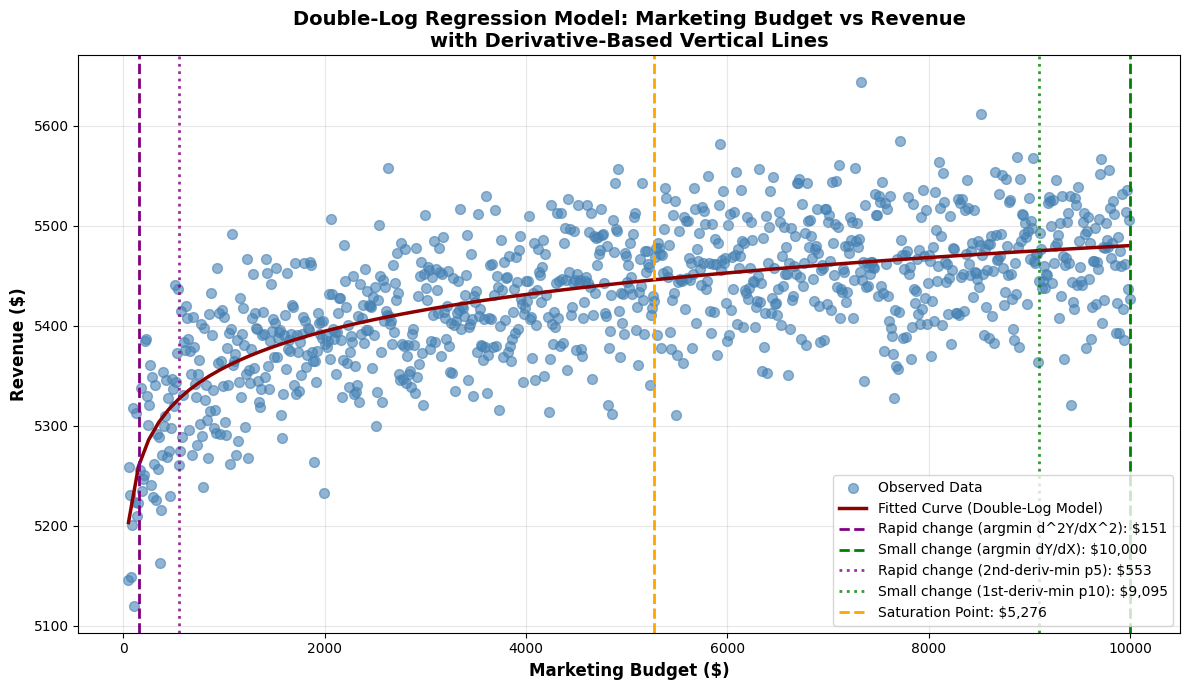

Mean budgetでの限界効果: 0.01
急激な変化（2階微分最小）: $151
変化量が小さい（1階微分最小）: $10,000
[参考] 2階微分最小5%-tile以上の最初の点: $553
[参考] 1階微分最小10%-tile以下の最初の点: $9,095
✓ 可視化完了


In [189]:
import matplotlib.pyplot as plt

# x_range を Series 化（.values を期待する実装に対応）
x_plot = pd.Series(x_range, name="Marketing")
x_values = x_plot.to_numpy()

# 両対数モデルの予測値
y_pred = doublog_model.predict(x_plot)
y_pred = np.asarray(y_pred).reshape(-1)

# 飽和点情報
saturation = doublog_calc.detect_saturation_point("Marketing", x_plot)

# 1階・2階微分（数値微分）
first_derivative = np.gradient(y_pred, x_values)
second_derivative = np.gradient(first_derivative, x_values)

# 要件に対応した代表点
x_rapid_change = float(x_values[np.argmin(second_derivative)])  # 2階微分最小（急激な変化）
x_small_change = float(x_values[np.argmin(first_derivative)])  # 1階微分最小

# %-tileベースの補助指標（境界値に寄りやすい問題への補助）
first_p10 = float(np.percentile(first_derivative, 10))
second_p5 = float(np.percentile(second_derivative, 5))
x_small_change_p10 = float(x_values[np.where(first_derivative <= first_p10)[0][0]])
x_rapid_change_p5 = float(x_values[np.where(second_derivative > second_p5)[0][0]])

# プロット
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(
    df_doublog["Marketing"],
    df_doublog["Revenue"],
    alpha=0.6,
    s=50,
    label="Observed Data",
    color="steelblue",
)

ax.plot(
    x_values,
    y_pred,
    color="darkred",
    linewidth=2.5,
    label="Fitted Curve (Double-Log Model)",
)

x_mean_doublog = df_doublog["Marketing"].mean()
me_at_mean = doublog_calc.marginal_effect("Marketing", mean_value=x_mean_doublog)
# ax.axvline(
#     x=x_mean_doublog,
#     color="red",
#     linestyle="--",
#     linewidth=2,
#     label=f"Evaluation X (Mean Budget): ${x_mean_doublog:,.0f}",
# )

ax.axvline(
    x=x_rapid_change,
    color="purple",
    linestyle="--",
    linewidth=2,
    label=f"Rapid change (argmin d^2Y/dX^2): ${x_rapid_change:,.0f}",
)

ax.axvline(
    x=x_small_change,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Small change (argmin dY/dX): ${x_small_change:,.0f}",
)

# %-tileベースの補助線（比較用）
ax.axvline(
    x=x_rapid_change_p5,
    color="purple",
    linestyle=":",
    linewidth=2,
    alpha=0.8,
    label=f"Rapid change (2nd-deriv-min p5): ${x_rapid_change_p5:,.0f}",
)

ax.axvline(
    x=x_small_change_p10,
    color="green",
    linestyle=":",
    linewidth=2,
    alpha=0.8,
    label=f"Small change (1st-deriv-min p10): ${x_small_change_p10:,.0f}",
)

if saturation["saturation_threshold_x"] is not None:
    ax.axvline(
        x=saturation["saturation_threshold_x"],
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"Saturation Point: ${saturation['saturation_threshold_x']:,.0f}",
    )

ax.set_xlabel("Marketing Budget ($)", fontsize=12, fontweight="bold")
ax.set_ylabel("Revenue ($)", fontsize=12, fontweight="bold")
ax.set_title(
    "Double-Log Regression Model: Marketing Budget vs Revenue\n"
    "with Derivative-Based Vertical Lines",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean budgetでの限界効果: {me_at_mean:,.2f}")
print(f"急激な変化（2階微分最小）: ${x_rapid_change:,.0f}")
print(f"変化量が小さい（1階微分最小）: ${x_small_change:,.0f}")
print(f"[参考] 2階微分最小5%-tile以上の最初の点: ${x_rapid_change_p5:,.0f}")
print(f"[参考] 1階微分最小10%-tile以下の最初の点: ${x_small_change_p10:,.0f}")
print("✓ 可視化完了")

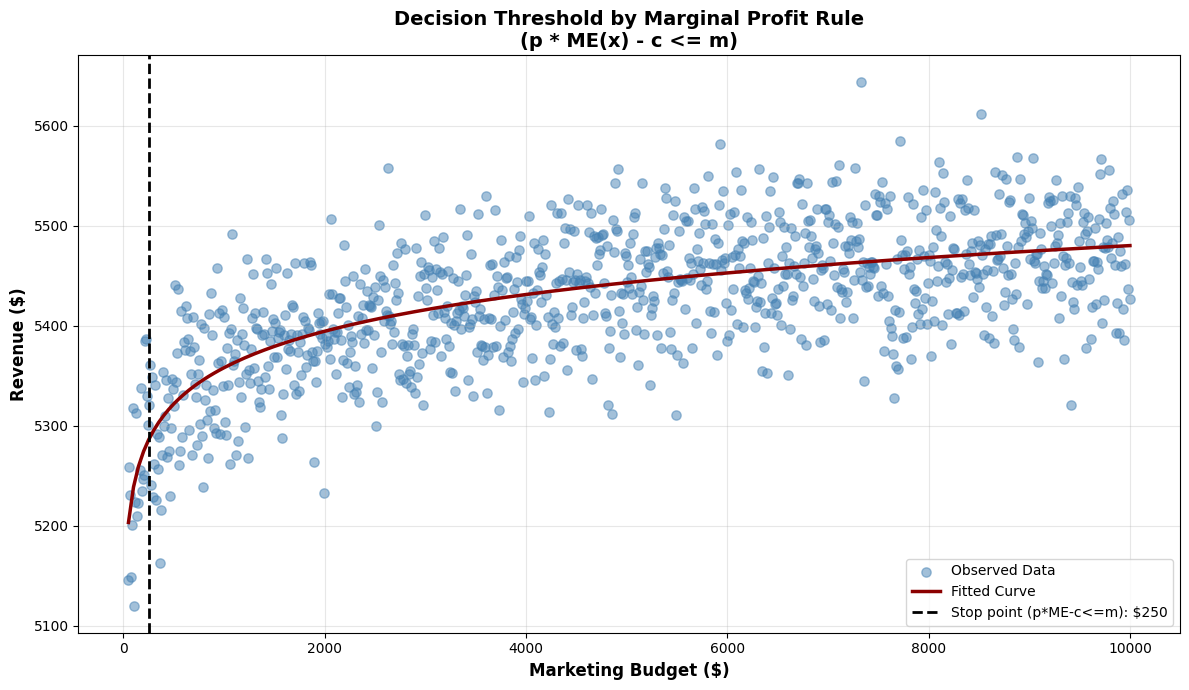

設定値: p=100.0, c=20.0, m=1.1
停止点: $250
停止点でのME: 0.2096
停止点での p*ME-c: 0.9620


In [226]:
# ROIベースの停止点（p * ME(x) - c <= m）
import matplotlib.pyplot as plt

# ---- 意思決定パラメータ（ここを調整） ----
# Fixme: L社のドメイン知識を反映して、p, c, mに対する意味付けを行う。
# 計算式： p*ME(x)-c<=m
p = 100.0  # 成果1単位あたり価値(反響単価)
c = 20.0  # 追加投下1単位あたりの限界費用(Xを1件増やす場合の追加コスト)
m = 1.1 # 現行反響単価に対する倍率

# 評価グリッドと予測
x_eval = np.linspace(df_doublog["Marketing"].min(), df_doublog["Marketing"].max(), 200)
x_eval_series = pd.Series(x_eval, name="Marketing")
y_eval = np.asarray(doublog_model.predict(x_eval_series)).reshape(-1)

# 限界効果（数値微分）と限界利益
me_eval = np.gradient(y_eval, x_eval)
net_marginal_profit = p * me_eval - c

# 最初に条件を満たす停止点
stop_candidates = np.where(net_marginal_profit <= m)[0]
x_stop = float(x_eval[stop_candidates[0]]) if len(stop_candidates) > 0 else None

# 可視化
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(
    df_doublog["Marketing"],
    df_doublog["Revenue"],
    alpha=0.5,
    s=45,
    color="steelblue",
    label="Observed Data",
)
ax.plot(
    x_eval,
    y_eval,
    color="darkred",
    linewidth=2.5,
    label="Fitted Curve",
)

if x_stop is not None:
    ax.axvline(
        x=x_stop,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Stop point (p*ME-c<=m): ${x_stop:,.0f}",
    )

ax.set_xlabel("Marketing Budget ($)", fontsize=12, fontweight="bold")
ax.set_ylabel("Revenue ($)", fontsize=12, fontweight="bold")
ax.set_title(
    "Decision Threshold by Marginal Profit Rule\n"
    "(p * ME(x) - c <= m)",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"設定値: p={p}, c={c}, m={m}")
if x_stop is not None:
    me_at_stop = float(np.interp(x_stop, x_eval, me_eval))
    net_at_stop = float(p * me_at_stop - c)
    print(f"停止点: ${x_stop:,.0f}")
    print(f"停止点でのME: {me_at_stop:,.4f}")
    print(f"停止点での p*ME-c: {net_at_stop:,.4f}")
else:
    print("評価範囲内に停止点はありません（まだ投下余地あり）")

---

## まとめ

このウォークスルーでは、以下の手法を実演しました：

1. **線形回帰モデル**: 基本的な線形関係のモデル化
2. **限界効果分析**: 各説明変数が目的変数に与える影響の定量化
3. **弾力性分析**: パーセンテージ変化に対する反応度の計測
4. **応答性分析**: 特定の変数の変化に対する詳細な応答測定
5. **両対数モデル**: 非線形の逓減効果を含むモデルの推定
6. **飽和点検出**: 効果の飽和ポイントの識別

これらのツールを組み合わせることで、経済的な意思決定に必要な定量的な情報が得られます。